### Set up google colab runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 376 kB 38.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bbe1447206c42d2827e012928d145175c142ffc3d61c2ebf1c1bed5a12601acd
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ec9759c54a0e1f8e4993a965ab26c4b9ca6eee854fa75128204c958efbfe3bf5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-5o4h21h2
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-5o4h21h2
   

### Download Dataset

In [2]:
!git clone https://github.com/Sumeet226/Human-Image-Segmentation.git

Cloning into 'Human-Image-Segmentation'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (617/617), done.
remote: Compressing objects: 100% (611/611), done.
remote: Total 617 (delta 15), reused 589 (delta 2), pack-reused 0
Receiving objects: 100% (617/617), 13.61 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (15/15), done.


### Imports

In [3]:
import sys
sys.path.append('/content/Dataset')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from tqdm import tqdm
import albumentations as A

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from sklearn.model_selection import train_test_split

### Configs

In [5]:
# setting device on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 25
LR = 0.003

TEST_SIZE = 0.2
IMAGE_SIZE = 320 # Target image and mask size
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

### Load the data

In [6]:
# ROOT_DIR = os.getcwd()
# DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')

# IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
# MASKS_DIR = os.path.join(DATASET_DIR, 'masks')

DATASET_DIR = '/content/Human-Image-Segmentation/Dataset'

IMAGES_DIR = DATASET_DIR + '/images'
MASKS_DIR = DATASET_DIR + '/masks'

In [7]:
IMAGES_DIR

'/content/Human-Image-Segmentation/Dataset/images'

In [8]:
images_names = [f for f in os.listdir(IMAGES_DIR) if not f.startswith('.')]
masks_names = [f for f in os.listdir(MASKS_DIR) if not f.startswith('.')]
# To avoid files like .ipynb_checkpoints from being read

print(f"Number of images: {len(images_names)}")
print(f"Number of masks: {len(masks_names)}")

Number of images: 290
Number of masks: 290


### Check image-mask correspondance

In [9]:
for i, (image, mask) in enumerate(zip(images_names, masks_names)):
    print(image, mask)
    if (i + 1) % 5 == 0:
        break

72.jpg 6.png
75.jpg 12.png
30.jpg 209.png
183.jpg 116.png
33.jpg 155.png


In [10]:
# Since image and mask name are not corresponding, we sort them
images_names.sort()
masks_names.sort()

In [11]:
img_mask_not_corr = False

for idx in range(len(images_names)):
    image = images_names[idx]
    mask = masks_names[idx]
    if image.split('.')[0] != mask.split('.')[0]:
        img_mask_not_corr = True
        break
        
if img_mask_not_corr:
    print("All images don't have a corresponding mask!")
else:
    print("All images have a corresponding mask")

All images have a corresponding mask


### Create a DataFrame and a CSV file

In [12]:
df = pd.DataFrame({
    'images': [os.path.join(IMAGES_DIR, image) for image in images_names], 
    'masks': [os.path.join(MASKS_DIR, mask) for mask in masks_names],
})

df.head()

,images,masks
0,/content/Human-Image-Segmentation/Dataset/imag...,/content/Human-Image-Segmentation/Dataset/mask...
1,/content/Human-Image-Segmentation/Dataset/imag...,/content/Human-Image-Segmentation/Dataset/mask...
2,/content/Human-Image-Segmentation/Dataset/imag...,/content/Human-Image-Segmentation/Dataset/mask...
3,/content/Human-Image-Segmentation/Dataset/imag...,/content/Human-Image-Segmentation/Dataset/mask...
4,/content/Human-Image-Segmentation/Dataset/imag...,/content/Human-Image-Segmentation/Dataset/mask...


In [13]:
# Save the above dataframe to a csv file
df.to_csv('train.csv', index = False)

### Visualize the data

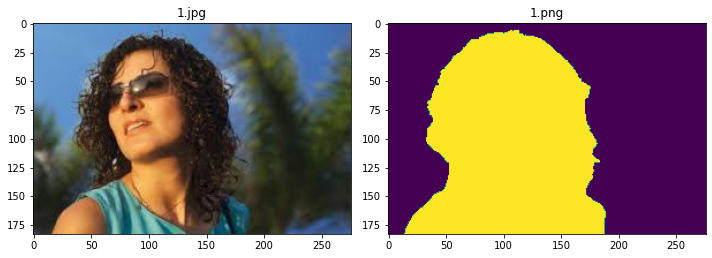

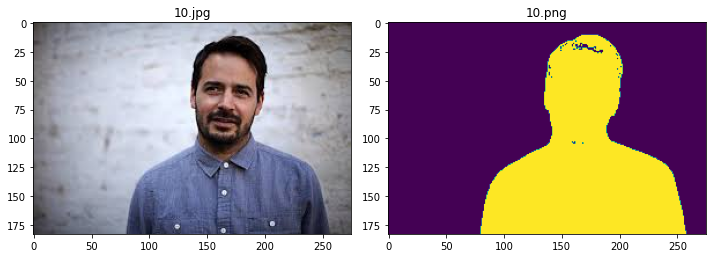

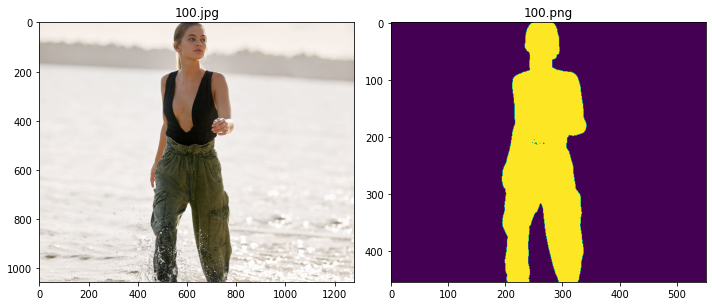

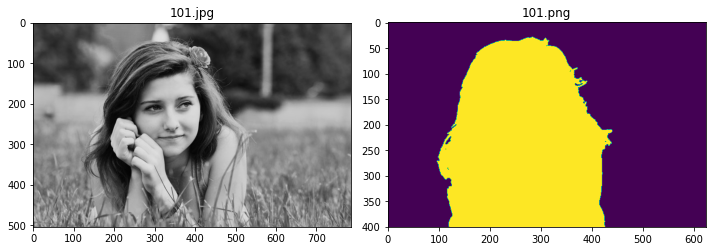

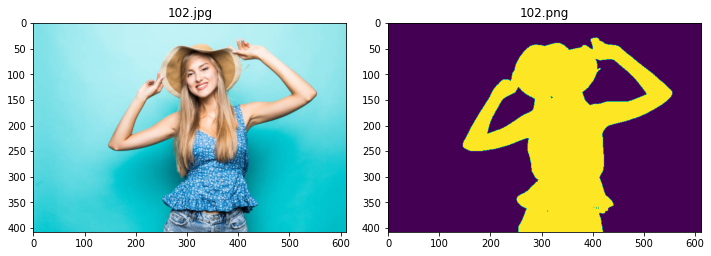

In [14]:
num_samples = 5 

for idx in range(num_samples):
    row = df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    
    image = cv2.imread(image_path)
    # OpenCV reads images in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    # As mask is going to grayscale
    
    NUM_ROWS = 1
    NUM_COLS = 2
    fig, ax = plt.subplots(NUM_ROWS, NUM_COLS, figsize = (10, 5))
        
    ax[0].imshow(image)
    ax[0].grid(False)
    ax[0].set_title(image_path.split('/')[-1])

    ax[1].imshow(mask)
    ax[1].grid(False)
    ax[1].set_title(mask_path.split('/')[-1])

    plt.tight_layout()
    plt.show()

### Splitting the training and validation data

In [15]:
train_df, valid_df = train_test_split(df, test_size = TEST_SIZE, random_state = 42)

print(f"Length of training data: {len(train_df)}")
print(f"Length of validation data: {len(valid_df)}")

Length of training data: 232
Length of validation data: 58


### Visualization helper function

In [16]:
def show_image(image, mask, pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
        
        ax1.set_title('Image')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap = 'gray')
        
        ax2.set_title('Ground Truth')
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (10, 5))
        
        ax1.set_title('Image')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap = 'gray')
        
        ax2.set_title('Ground Truth')
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap = 'gray')
        
        ax3.set_title('Model Output')
        ax3.imshow(pred_image.permute(1, 2, 0).squeeze(), cmap = 'gray')

### Augmentation Functions
albumentation documentation : https://albumentations.ai/docs/

In [17]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
        A.HorizontalFlip(p = 0.5), 
        A.VerticalFlip(p = 0.5), 
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
    ])

### Create Custom Dataset

In [18]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
        mask = np.expand_dims(mask, axis = -1) # (h, w, c)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            # This augmentation is holding image and mask in dictionary format
            image = data['image']
            mask = data['mask']

            # (h, w, c) -> (c, h, w)

            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

            image = torch.Tensor(image) / 255.0
            mask = torch.round(torch.Tensor(mask) / 255.0)
            # To round mask values to 0 and 1

            return image, mask

In [19]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


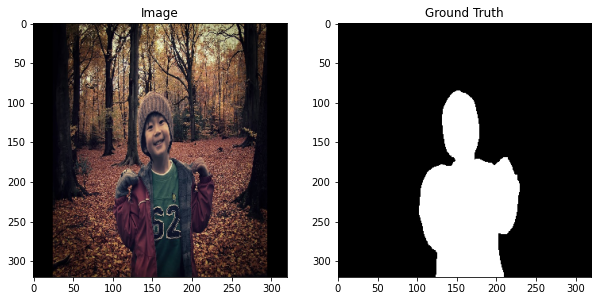

In [20]:
idx = 21

image, mask = trainset[idx]
show_image(image, mask)

### Load dataset into batches

In [21]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(f"Total no. of batches in trainloader: {len(trainloader)}")
print(f"Total no. of batches in validloader: {len(validloader)}")

Total no. of batches in trainloader: 15
Total no. of batches in validloader: 4


In [22]:
232 / 16

14.5

In [23]:
58 / 16

3.625

In [24]:
for image, mask in trainloader:
    break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


### Create Segmentation Model
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [25]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.architecture = smp.Unet(
            encoder_name = ENCODER, 
            encoder_weights = WEIGHTS, 
            in_channels = 3, 
            classes = 1,
            activation = None
        )

    def forward(self, images, masks = None):

        logits = self.architecture(images)

        if masks != None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks) # Binary Cross Entropy Loss
            return logits, loss1 + loss2
        
        return logits

In [26]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (architecture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2

### Create Train and Validation Function 

In [27]:
def train_fn(data_loader, model, optimizer):
    
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad() # Make sure gradients are 0
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [28]:
def eval_fn(data_loader, model):
    
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

### Train the model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [30]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt') # pt==pytorch
        print("SAVED MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch: {i + 1} Train_loss: {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


SAVED MODEL
Epoch: 1 Train_loss: 0.8056749006112417 Valid_loss : 0.8279905617237091


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 2 Train_loss: 0.37171198924382526 Valid_loss : 1.176606371998787


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


SAVED MODEL
Epoch: 3 Train_loss: 0.32232039570808413 Valid_loss : 0.33841589093208313


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVED MODEL
Epoch: 4 Train_loss: 0.28082326153914133 Valid_loss : 0.2891632691025734


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED MODEL
Epoch: 5 Train_loss: 0.2614044080177943 Valid_loss : 0.22152680531144142


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch: 6 Train_loss: 0.2231401989857356 Valid_loss : 0.29829006269574165


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


SAVED MODEL
Epoch: 7 Train_loss: 0.21102456798156102 Valid_loss : 0.18208638951182365


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch: 8 Train_loss: 0.1843362202246984 Valid_loss : 0.19386664405465126


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 9 Train_loss: 0.16300251185894013 Valid_loss : 0.27575449272990227


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch: 10 Train_loss: 0.18702144821484884 Valid_loss : 0.2255193293094635


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 11 Train_loss: 0.16892125755548476 Valid_loss : 0.22328881733119488


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


SAVED MODEL
Epoch: 12 Train_loss: 0.17720222075780231 Valid_loss : 0.1815810613334179


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 13 Train_loss: 0.15141723851362865 Valid_loss : 0.19809943437576294


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 14 Train_loss: 0.13122661660114923 Valid_loss : 0.21847186610102654


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


SAVED MODEL
Epoch: 15 Train_loss: 0.1300044536590576 Valid_loss : 0.17405075207352638


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch: 16 Train_loss: 0.13828392972548803 Valid_loss : 0.21102669462561607


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 17 Train_loss: 0.17672192404667536 Valid_loss : 0.2665107697248459


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Epoch: 18 Train_loss: 0.14908304711182913 Valid_loss : 0.25482598692178726


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch: 19 Train_loss: 0.1591069350639979 Valid_loss : 0.215255219489336


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch: 20 Train_loss: 0.16152729342381159 Valid_loss : 0.29163186624646187


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 21 Train_loss: 0.13485319713751476 Valid_loss : 0.25529057160019875


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch: 22 Train_loss: 0.14126580109198889 Valid_loss : 0.25434692949056625


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 23 Train_loss: 0.17630291630824407 Valid_loss : 0.21841461583971977


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 24 Train_loss: 0.12914447287718456 Valid_loss : 0.19677241146564484


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Epoch: 25 Train_loss: 0.10808220207691192 Valid_loss : 0.20455674082040787


### Inference

In [31]:
idx = 2

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

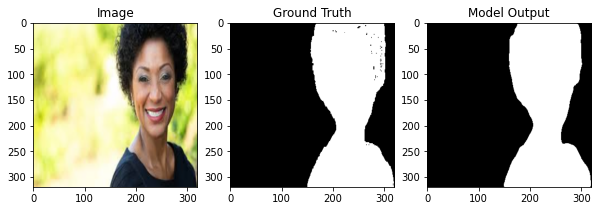

In [32]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))